<a href="https://colab.research.google.com/github/Calcifer777/learn-deep-learning/blob/main/generative-models/samples/WGAN_PL_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Other References

- https://github.com/Zeleni9/pytorch-wgan/
- https://www.kaggle.com/code/varnez/wgan-gp-cifar10-dogs-with-pytorch

In [1]:
%%bash

pip install -q torchinfo

In [2]:
!test -e samples/ || mkdir samples
!test -d "./samples/" && rm -r ./samples/*

In [3]:
from typing import List

from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from tqdm import tqdm

import torch
from torch import nn, Tensor
from torch.nn.functional import mse_loss
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as T
import torchvision.transforms.v2.functional as F
from torchvision.utils import make_grid
from torchvision.transforms import (
    Compose,
    PILToTensor,
)
from torchinfo import summary

In [4]:
torch.manual_seed(42)
np.random.seed(42)

In [5]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"{device = }")

device = 'cuda'


## Parameters

In [6]:
DATASET = "mnist"

EPOCHS = 50
BATCH_SIZE = 64
LATENT_DIM = 100
BASE_DIM_GEN = 4
BASE_GEN_CH = 256
CRITIC_TO_GEN_UPDATES = 5
GP_WEIGHT = 10.0
PATH_SAMPLES = Path(f"./samples/{DATASET}")

LR_G = 1e-4
LR_C = 1e-4
BETA = (0.0, 0.9)


In [7]:
PATH_SAMPLES.mkdir(exist_ok=True)

## Data

In [8]:
def resize(img):
    return img.resize((32, 32))

In [9]:
def inv_norm_img(img):
    return T.Compose([
        T.Normalize(0.0, 1/0.5),
        T.Normalize(-0.5, 1.0),
    ])(img)

In [10]:
ds_train = datasets.MNIST(
    "./data/mnist/",
    download=True,
    train=True,
    transform=T.Compose([
        resize,
        T.ToTensor(),
        T.Normalize(0.5, 0.5)
    ]),
)
ds_train_base = datasets.MNIST(
    "./data/mnist/",
    train=True,
    transform=resize,
)


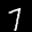

In [11]:
sample_image_base = ds_train_base[42][0]
arr_base = np.array(sample_image_base)
sample_image_base

In [12]:
sample_image = ds_train[42][0]
print(
    f"{sample_image.shape = }",
    f"{sample_image.min().item() = }",
    f"{sample_image.max().item() = }",
    sep="\n",
)
arr_rec = np.array(F.to_pil_image(inv_norm_img(sample_image)))

sample_image.shape = torch.Size([1, 32, 32])
sample_image.min().item() = -1.0
sample_image.max().item() = 1.0


In [13]:
np.abs(arr_base - arr_rec).mean()

0.0478515625

In [14]:
dl_train = DataLoader(
    dataset=ds_train,
    batch_size=BATCH_SIZE,
)

In [15]:
sample_batch = next(iter(dl_train))
sample_batch[0].shape

torch.Size([64, 1, 32, 32])

## Models

In [16]:
class Critic(nn.Module):

    def __init__(self, *args, **kwargs):
        super(Critic, self).__init__(*args, **kwargs)
        self.net = nn.Sequential(
            self.conv_block(1, 16),
            self.conv_block(16, 32),
            self.conv_block(32, 64),
            nn.Conv2d(64, 1, kernel_size=4),
            nn.Flatten(),
        )

    @staticmethod
    def conv_block(
        in_ch: int,
        out_ch: int,
        activation: bool = True,
        padding: str | int = 1,
        kernel_size=4,
    ) -> Tensor:
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=2, padding=padding),
        ]
        if activation:
            layers.extend([
                nn.InstanceNorm2d(num_features=out_ch, affine=True),
                nn.LeakyReLU(0.2),
            ])
        return nn.Sequential(*layers)


    def forward(self, x: Tensor):
        x = self.net(x)
        return x

In [17]:
x = torch.rand((2, 1, 32, 32))
summary(Critic(), input_data=(x))

Layer (type:depth-idx)                   Output Shape              Param #
Critic                                   [2, 1]                    --
├─Sequential: 1-1                        [2, 1]                    --
│    └─Sequential: 2-1                   [2, 16, 16, 16]           --
│    │    └─Conv2d: 3-1                  [2, 16, 16, 16]           272
│    │    └─InstanceNorm2d: 3-2          [2, 16, 16, 16]           32
│    │    └─LeakyReLU: 3-3               [2, 16, 16, 16]           --
│    └─Sequential: 2-2                   [2, 32, 8, 8]             --
│    │    └─Conv2d: 3-4                  [2, 32, 8, 8]             8,224
│    │    └─InstanceNorm2d: 3-5          [2, 32, 8, 8]             64
│    │    └─LeakyReLU: 3-6               [2, 32, 8, 8]             --
│    └─Sequential: 2-3                   [2, 64, 4, 4]             --
│    │    └─Conv2d: 3-7                  [2, 64, 4, 4]             32,832
│    │    └─InstanceNorm2d: 3-8          [2, 64, 4, 4]             128
│    │

In [18]:
class Generator(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Generator, self).__init__(*args, **kwargs)
        self.net = nn.Sequential(
            nn.Unflatten(2, (1, 1)),
            self.conv_block(100, 512, kernel_size=4, stride=1, padding=0),
            self.conv_block(512, 256, kernel_size=4, stride=2, padding=1),
            self.conv_block(256, 128, kernel_size=4, stride=2, padding=1),
            self.conv_block(128, 64, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
        )

    @staticmethod
    def conv_block(
        in_ch: int,
        out_ch: int,
        kernel_size: int = 4,
        stride: int = 2,
        padding: int = 1,
    ):
        # Base
        layers = [
            nn.ConvTranspose2d(
                in_ch,
                out_ch,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
        ]
        return nn.Sequential(*layers)

    def forward(self, x: Tensor):
        return self.net(x)

In [19]:
z = torch.rand((2, 100, 1))
summary(Generator(), input_data=z)

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [2, 1, 32, 32]            --
├─Sequential: 1-1                        [2, 1, 32, 32]            --
│    └─Unflatten: 2-1                    [2, 100, 1, 1]            --
│    └─Sequential: 2-2                   [2, 512, 4, 4]            --
│    │    └─ConvTranspose2d: 3-1         [2, 512, 4, 4]            819,712
│    │    └─BatchNorm2d: 3-2             [2, 512, 4, 4]            1,024
│    │    └─ReLU: 3-3                    [2, 512, 4, 4]            --
│    └─Sequential: 2-3                   [2, 256, 8, 8]            --
│    │    └─ConvTranspose2d: 3-4         [2, 256, 8, 8]            2,097,408
│    │    └─BatchNorm2d: 3-5             [2, 256, 8, 8]            512
│    │    └─ReLU: 3-6                    [2, 256, 8, 8]            --
│    └─Sequential: 2-4                   [2, 128, 16, 16]          --
│    │    └─ConvTranspose2d: 3-7         [2, 128, 16, 16]          52

## Train

In [20]:
generator = Generator().to(device)
critic = Critic().to(device)

opt_g = torch.optim.Adam(generator.parameters(), lr=LR_G, betas=BETA)
opt_c = torch.optim.Adam(critic.parameters(), lr=LR_C, betas=BETA)

In [21]:
def sample_latent(batch_size: int):
    return (
        torch.distributions.Normal(0, 1)
        .sample((batch_size, LATENT_DIM, 1))
        .to(device)
    )

In [22]:
def gradient_penalty(batch: Tensor, img_gen: Tensor, critic_model: Critic) -> Tensor:
    """ MSE loss w.r.t. 1 of gradients from scores of interpolated images """
    eps = torch.rand((batch.shape[0], 1, 1, 1)).to(device)
    eps = eps.expand_as(eps)
    interp = eps * batch + (1-eps) * img_gen
    interp = torch.autograd.Variable(interp, requires_grad=True)
    scores = critic_model(interp)
    gradients = torch.autograd.grad(
        outputs=scores,
        inputs=interp,
        grad_outputs=torch.ones_like(scores),
        create_graph=True,
        retain_graph=True,
    )[0]  # take gradients w.r.t to the (only) input
    gradients_flt = gradients.view(gradients.shape[0], -1)  # reshape batch x -1
    norm = gradients_flt.norm(2, dim=-1)
    gp = mse_loss(norm, torch.ones_like(norm))
    return gp

In [23]:
l = sample_latent(BATCH_SIZE)
gradient_penalty(
    sample_batch[0].cuda(),
    Generator().to(device)(l),  # throwaway model
    Critic().to(device),  # throwaway model
)

tensor(1.0395, device='cuda:0', grad_fn=<MseLossBackward0>)

In [24]:
def train_step_c(batch):
    opt_c.zero_grad()
    z = sample_latent(batch.shape[0])
    img_gen = generator(z).detach()  # detach probably not needed
    score_real = critic(batch)
    score_gen = critic(img_gen)
    loss_w = - score_real.mean() + score_gen.mean()
    gp = gradient_penalty(batch=batch, img_gen=img_gen, critic_model=critic)
    loss = loss_w + GP_WEIGHT * gp
    loss.backward()
    opt_c.step()
    return dict(
        loss_c=loss.item(),
        loss_c_w=loss_w.item(),
        gp=gp.item(),
        score_real=score_real.mean().item(),
        score_gen=score_gen.mean().item(),
    )

In [25]:
def train_step_g(batch):
    opt_g.zero_grad()
    z = sample_latent(batch.shape[0])
    img_gen = generator(z)
    score_gen = critic(img_gen)
    loss = - score_gen.mean()
    loss.backward()
    opt_g.step()
    return dict(
        loss_g=loss.item(),
    )

In [26]:
%matplotlib inline

def live_plot(metrics: List[dict], title=''):
    """
    0. List[Dict[str, float]]
    1. pd.DataFrame
    2. Column-wise running mean
    3. Dict[str, List[float]]
    """
    df = pd.DataFrame.from_records(metrics).rolling(50).mean()
    data_dict = df.to_dict(orient="list")
    #
    clear_output(wait=True)
    fig, axes = plt.subplots(2, 3, figsize=(12, 6))
    for ax, (k, v) in zip(axes.flatten(), data_dict.items()):
        ax.plot(v)
        ax.set_title(k)
    plt.grid(False)
    plt.show();

In [27]:
def apply_along_axis(function, x, axis: int = 0):
    return torch.stack([
        function(x_i) for x_i in torch.unbind(x, dim=axis)
    ], dim=axis)

In [28]:
@torch.inference_mode()
def generate_samples(n: int = 25):
    generator.eval()
    z = sample_latent(n)
    x = generator(z)
    x = x.cpu()
    x = apply_along_axis(inv_norm_img, x)
    # >>> DEBUG
    arr = x.numpy()
    assert np.logical_and(arr >= 0, arr <= 255).all()
    # <<< DEBUG
    grid = make_grid(x, nrow=5)
    img = F.to_pil_image(grid)
    return img

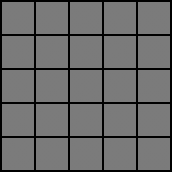

In [29]:
# Before training this should be random noise
generate_samples()

In [30]:
def train_epoch(epoch_id: int, history: List[dict]):
    pbar = tqdm(enumerate(dl_train, start=1), total=len(dl_train))
    for i, (batch, _) in pbar:
        generator.train()
        critic.train()
        batch = batch.to(device)
        for j in range(CRITIC_TO_GEN_UPDATES):
            loss_c = train_step_c(batch)
        loss_g = train_step_g(batch)
        metrics = {**loss_c, **loss_g}
        history.append(metrics)
        if i % 125 == 0:
            live_plot(history)
        if i % 250 == 0:
            samples = generate_samples()
            samples.save(PATH_SAMPLES / f"e{epoch_id:03d}_{i:04d}.png")
    return history

In [31]:
history = []

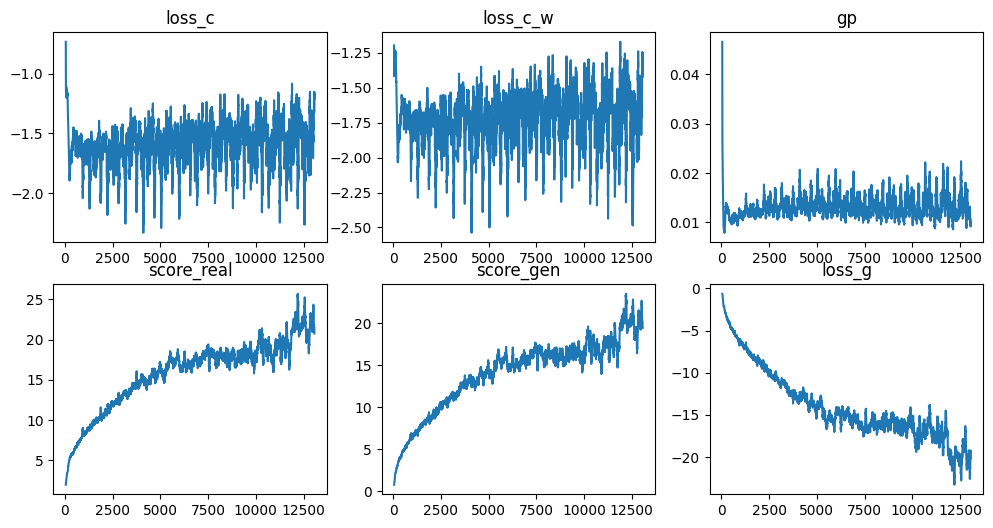

  2%|▏         | 16/938 [00:01<01:51,  8.24it/s]

In [ ]:
for epoch_id in range(EPOCHS):
    history = train_epoch(epoch_id, history)

## Generate samples

In [ ]:
generate_samples()